In [1]:
import sys
!{sys.executable} -m pip install scikit-image

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython.display as ipd
from environment import *

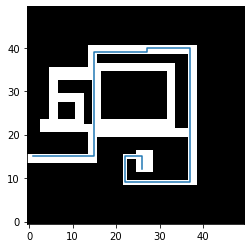

In [3]:
## Step 1: Create the world and devise robot motion
# Load in a particular environment
env = Environment("Maze1.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [27, 40], [26, 12]])
# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
#alpha = 0.1
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 
# Create a list of scans.  Each scan holds a list of "res" laser ranges across all angles
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]

In [4]:
#state_scans = env.get_state_scans(res)
#print(state_scans)

In [5]:
    def get_measurement_prob(xs, rs, alpha, gamma = 0.1):
        
        prob = 1
        
        for i in range(len(rs)):
            ri = rs[i]
            xi = xs[i]
            fract = 1/(np.sqrt(2*np.pi)*(alpha*ri+gamma))
            expo = np.exp(-1*(((xi-ri)**2) / (2*((alpha*ri)+gamma)**2)))
            prob *= fract*expo
        
        return prob


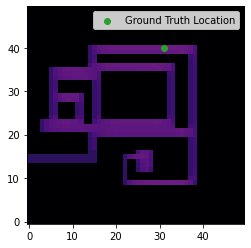

In [6]:
state_scans = env.get_state_scans(res)
N = len(state_scans)
# Compute the measurement probability of the scan at each location
meas_probs = np.zeros(N)
idx = 55
for i in range(N):
    meas_probs[i] = get_measurement_prob(observed_scans[idx], state_scans[i], alpha)
# Plot the measurement probabilities on the map
env.plot_probabilities(meas_probs, p=1e-2, show_max=False)
# Plot the ground truth location from the trajectory as an green dot
plt.scatter([X[idx, 0]], X[idx, 1], c='C2') 
plt.legend(["Ground Truth Location"])

MovieWriter ffmpeg unavailable; using Pillow instead.


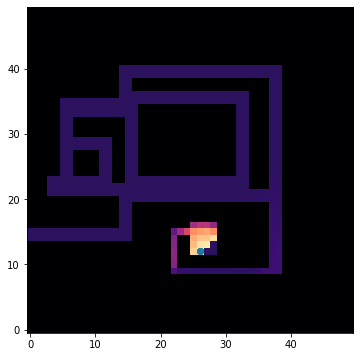

In [7]:
#def get_scan_desparity():
frames = [] # for storing the generated images
fig = plt.figure(figsize=(6, 6))
#N = env.X.shape[0] # Number of states
#probs = np.zeros(N)
K = len(state_scans) # Number of states
T = X.shape[0] # Number of timesteps
probs = np.zeros(K)
## TODO: Setup initial probabilities, etc
#for i in range(X.shape[0]): # Filter every measurement that comes in
f = np.ones(K)/K
for n in range(T):
## TODO: Bayes filtering for this frame index
    g = np.zeros(K)

    for k in range(K):
        #compare observed_scans[n] to state_scans[k]  
        meas = get_measurement_prob(observed_scans[n], state_scans[k], alpha)
        trans = 0
        for j in env.neighbors[k]:
            trans = trans + f[j] * (1/len(env.neighbors[j]))
        g[k] = meas * trans
    sigma = np.sum(g)

    f = g/sigma   

    plot = env.plot_probabilities(f, p=1e-2)
    plot.append(plt.scatter([X[n, 0]], [X[n, 1]], c='C0'))
    frames.append(plot)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
#ipd.HTML(ani.to_html5_video())
ani.save("result.gif")